In [1]:
from matplotlib import pyplot as plt 
from photutils import * 
import glob
import pandas as pd

# --- Astronomy Related Packages --- 
from photutils import *
from astropy import wcs
from astropy.io import fits
from astropy.stats import mad_std
from photutils import DAOStarFinder
from astropy.visualization import *
from astrofyp_functions import *
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [2]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': True,
#                             # Use the Computer modern font
#                             'font.family': 'serif',
#                             'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

### DAO Starfinder 

In [3]:
def starfinder(data, fwhm, plot_cond):
    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm, threshold = 5*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(data, vmin = data.mean() - data.std(), vmax = data.mean() + data.std(), cmap = 'gist_yarg')
        plt.show()

    return mst_sources

def save_Qtable(Qtable, filename):
    df = Qtable.to_pandas()
    df.to_csv(filename)
    

In [4]:
target_filelist = sorted(glob.glob('astrometric_obs_data/*_wcs.fits'))
target_filelist

['astrometric_obs_data/Bochum2_B_wcs.fits',
 'astrometric_obs_data/Bochum2_V_wcs.fits',
 'astrometric_obs_data/NGC2324_B_wcs.fits',
 'astrometric_obs_data/NGC2324_V_wcs.fits',
 'astrometric_obs_data/NGC2355_B_wcs.fits',
 'astrometric_obs_data/NGC2355_V_wcs.fits',
 'astrometric_obs_data/berkeley28_B_wcs.fits',
 'astrometric_obs_data/berkeley28_V_wcs.fits']

astrometric_obs_data/berkeley28_B_wcs.fits
astrometric_obs_data/berkeley28_V_wcs.fits


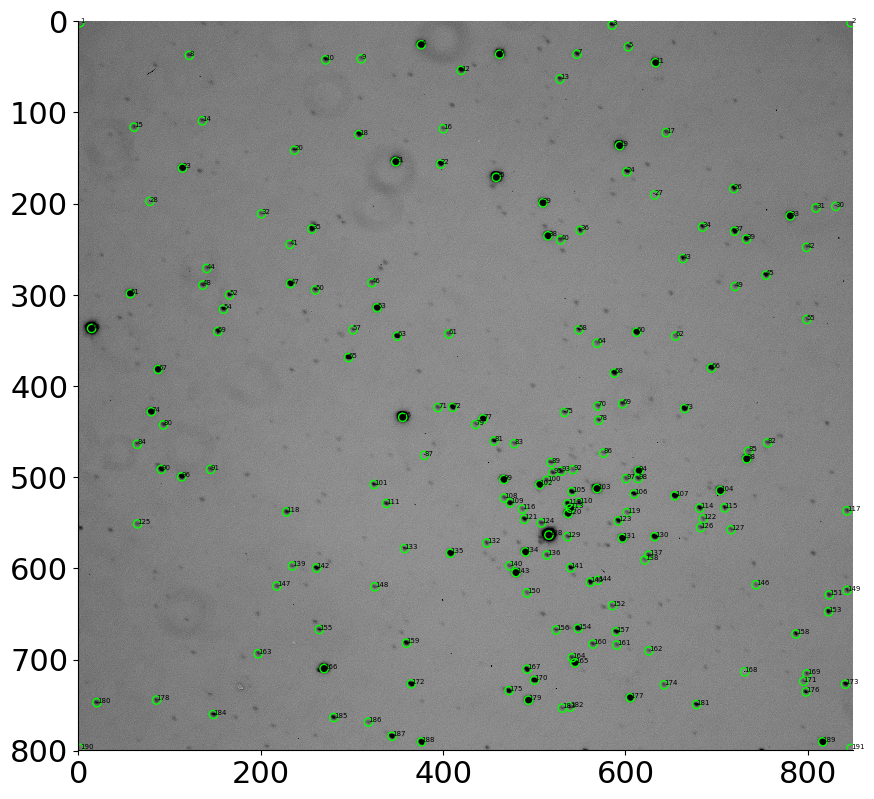

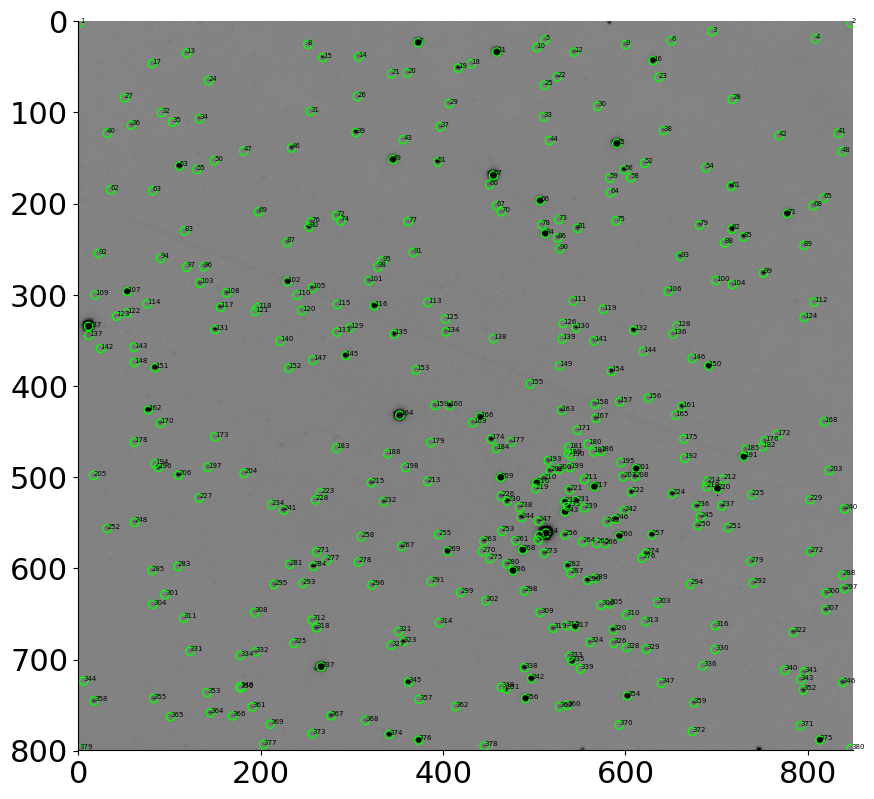

In [122]:
filename_B = target_filelist[6]; print(filename_B)
filename_V = target_filelist[7]; print(filename_V)

target_nameB = filename_B[21:-8]
target_nameV = filename_V[21:-8]

image_B = fits.getdata(filename_B)
image_V = fits.getdata(filename_V)

v_sources_raw = starfinder(image_V, 3.6, True)
b_sources_raw = starfinder(image_B, 4.2, True)

In [123]:
print(len(v_sources_raw))
print(len(b_sources_raw))

191
380


### Star Comparison 

In [124]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

Common Targets: 185


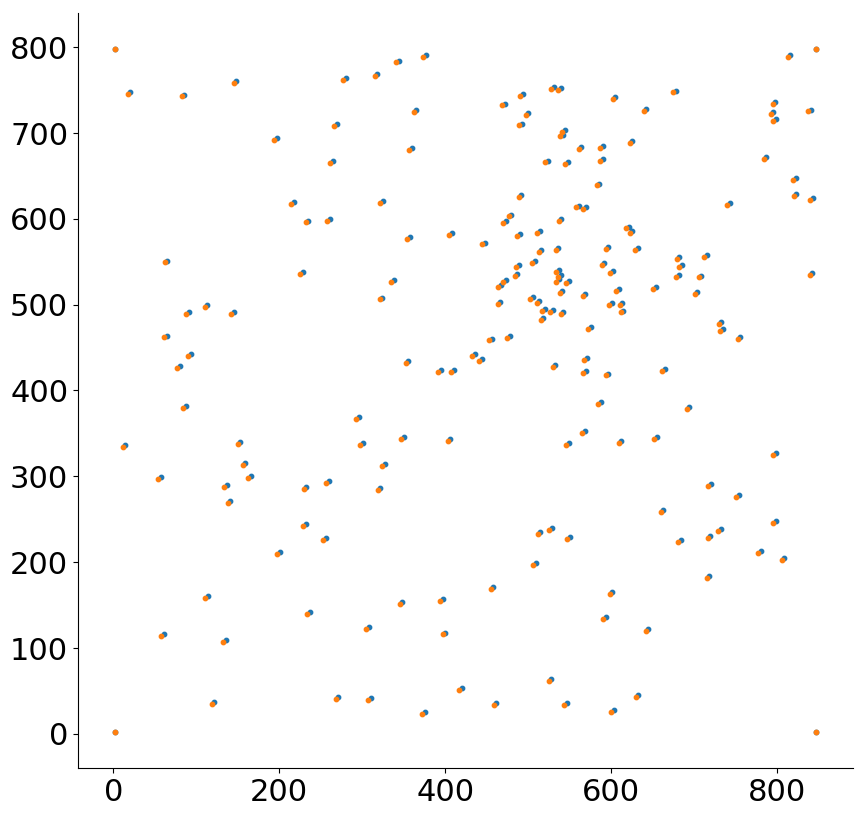

In [125]:
vhdulist = fits.open(filename_V)
v_wcs = wcs.WCS(vhdulist[0].header)
x_cordv = v_sources_raw['xcentroid']; y_cordv = v_sources_raw['ycentroid']
v_cord = v_wcs.pixel_to_world(x_cordv, y_cordv)

bhdulist = fits.open(filename_B)
x_cordb = b_sources_raw['xcentroid']; y_cordb = b_sources_raw['ycentroid']
b_wcs = wcs.WCS(bhdulist[0].header)
b_cord = b_wcs.pixel_to_world(x_cordb, y_cordb)
vcoord_index = []; bcoord_index = []

v_idx = 0
for cord in v_cord: 
    sep2tar = cord.separation(b_cord).degree
    if sep2tar.min() < 1.73e-3: 
        vcoord_index.append(v_idx)
        bcoord_index.append(np.argmin(sep2tar))
    v_idx += 1 

v_sources = v_sources_raw[vcoord_index]; b_sources = b_sources_raw[bcoord_index]

if len(v_sources) != len(b_sources):
    print('HALT!') 
else: 
    print('Common Targets:', len(v_sources))


plt.scatter(v_sources['xcentroid'], v_sources['ycentroid'], s = 10)
plt.scatter(b_sources['xcentroid'], b_sources['ycentroid'], s = 10)

## Aperture Photometry 

### Aperture Optimisation 

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

In [126]:
def star_distribution(sources): 
    bright_mask = sources.argsort(['flux']) # - creating mask for array so stars can be index in order of decending brightness 
    for i in range(0, len(sources)):
        test_stars = [sources['xcentroid'][bright_mask[i]], sources['ycentroid'][bright_mask[i]]]

        image = bhdulist[0].data
        x = int(test_stars[0]); y = int(test_stars[1])
    plt.plot(image[y, (x-10):(x+10)])

In [127]:
def aper_optimiser(file_name, sources, plot_cond, bkg_counts):
    # - background count - 
    image = fits.getdata(file_name)
    # bkg_mean = np.mean(image[x1:x2, y1:y2]) # - taking starless region from the frame as background. 
    bkg_mean = bkg_counts
    print('Bkg Mean:', bkg_mean)

    snr_values = []; opti_values = []
    trial_radius = np.arange(1, 10, 0.01) # - trial apertures. 

    for i in range(0, len(sources)):
        mask_idx = sources.argsort(['flux'])[i]
        test_stars = [sources['xcentroid'][mask_idx], sources['ycentroid'][mask_idx]]

        x = int(test_stars[0]); y = int(test_stars[1])

        apertures = [CircularAperture(test_stars, r=r) for r in trial_radius]
        phot_table = aperture_photometry(image, apertures)
        for col in phot_table.colnames:
            phot_table[col].info.format = '%.8g'

        snr = np.array([])
        index = 0
        for col in phot_table.colnames[3:]:
            bkg_total = bkg_mean * apertures[index].area
            net_star = phot_table[col] - bkg_total
            snr = np.append(snr, net_star / np.sqrt(net_star + bkg_total))
            index += 1

        opti_aper = trial_radius[np.argmax(snr)]
        opti_values.append(opti_aper)
        snr_values.append(snr[np.argmax(snr)])

    snr_values = np.array(snr_values); opti_values = np.array(opti_values)
    mask_i = np.where(snr_values < 50)
    mean_thrs = opti_values[mask_i].mean()

    print('Optimum aperture thresehold overall:', opti_values.mean())
    print('Optimum aperture thresehold under 50 SNR:', mean_thrs)

    if plot_cond == True: 
        plt.scatter(opti_values, snr_values, s = 10)
        plt.xlabel('Opti. Aperture Size'); plt.ylabel('SNR')
        plt.axvline(np.mean(opti_values), color = 'red', label = 'Mean Aper')
        plt.axhline(np.mean(snr_values), color = 'lime', label = 'Mean SNR')
        plt.scatter(opti_values, snr_values, s = 10)
        plt.legend()

    return mean_thrs, bkg_mean

In [128]:
print('TARGET ---', filename_V[21:-11])

print('B Filter:')
b_apr, b_bkg = aper_optimiser(filename_B, b_sources, False, 791)

print('V Filter')
v_apr, v_bkg = aper_optimiser(filename_V, v_sources, False, 792)

TARGET --- berkeley28
B Filter:
Bkg Mean: 791
Optimum aperture thresehold overall: 2.3404324324324333
Optimum aperture thresehold under 50 SNR: 2.2514371257485037
V Filter
Bkg Mean: 792
Optimum aperture thresehold overall: 4.220162162162165
Optimum aperture thresehold under 50 SNR: 4.2948125000000035


In [30]:
# from photutils.background import background_2d
# image = image_B
# x = Background2D(image, (50, 50), filter_size=(3, 3), sigma_clip=sigma_clip)
# print(x.background_rms_median)

# plt.title('RMS Estimated Background ')
# plt.imshow(x.background, origin='lower', cmap='Greys_r', interpolation='nearest')

---

In [99]:
def aper_photometry(data, sources, aper, bkg_counts):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    # Aperture  
    aperture = CircularAperture(positions, r=aper)
    phot_table = aperture_photometry(data  - bkg_counts, aperture)

    # # Now we get the final table of background subtracted counts for each star
    final_sum = phot_table['aperture_sum']

    return -2.5*np.log10(final_sum)

In [100]:
v_photometry = aper_photometry(image_V, v_sources, v_apr, v_bkg)
b_photometry = aper_photometry(image_B, b_sources, b_apr, b_bkg)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [101]:
# - writing to .csv 
photometry_data = [v_photometry, b_photometry]

photometry_df = pd.DataFrame(np.transpose(photometry_data)); photometry_df = photometry_df.rename(columns={0: "Vmag", 1: "Bmag"})
photometry_df.to_csv('calibration_parameters/magnitude_processing/raw_cluster_mags/%s.csv' % target_nameV)
photometry_df.head()

,Vmag,Bmag
0,-8.350476,-2.405299
1,-8.213498,NaN
2,-8.634789,-6.964629
3,-8.827193,-7.274113
4,-9.565481,-8.353053


Text(0, 0.5, 'V')

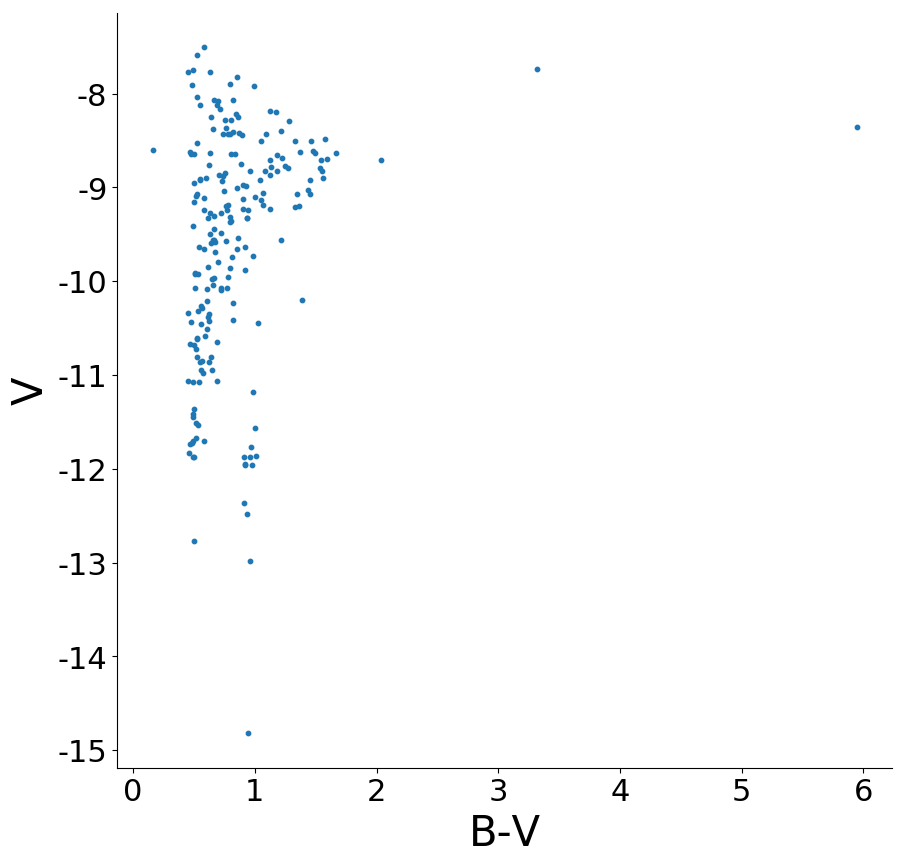

In [102]:
bv = b_photometry - v_photometry
v = v_photometry

# plt.gca().invert_yaxis()
plt.scatter(bv, v, s = 10)
plt.xlabel('B-V'); plt.ylabel('V')